# Processing of final output

In [2]:
# Traditional imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

## Method 1 : PIL library

In [3]:
# Music and image specific imports
from music21 import converter, instrument, note, chord, stream
from imageio import imwrite
from PIL import Image, ImageOps

### Test: opening image

In [3]:
image = ImageOps.grayscale(Image.open('../../data_test/Input_image_cleaned/ballade2/ballade2_instrument_0_0.png'))

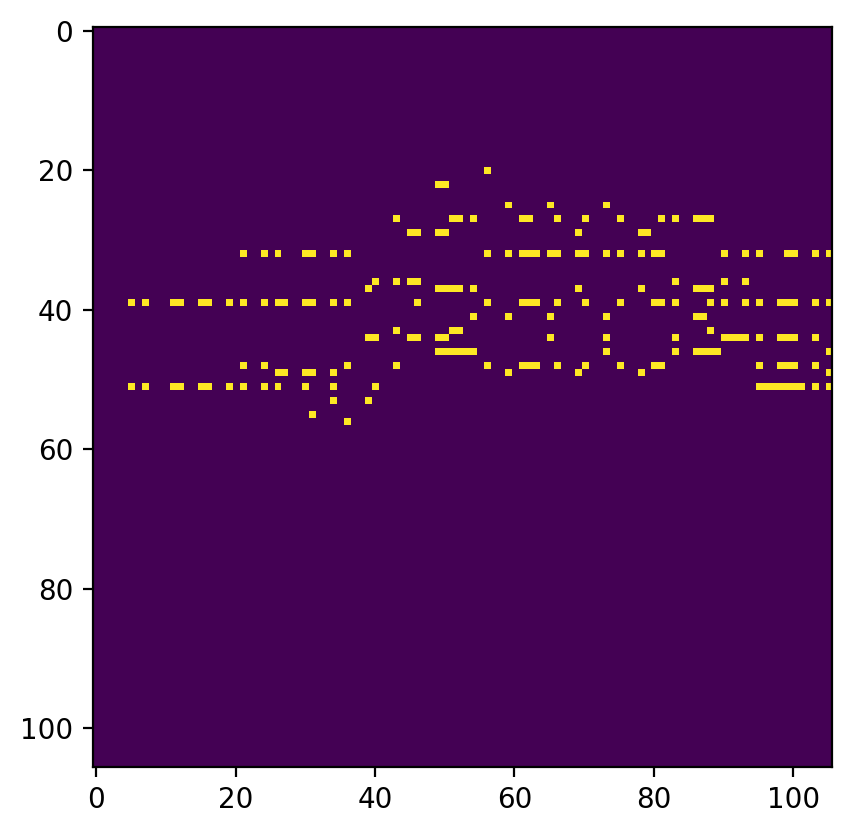

In [4]:
plt.imshow(image)

## Convert created image into a midi file

In [5]:
# Intermediary function
def column2notes(column, lowerBoundNote = 21):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

In [6]:
# Intermediary function
def updateNotes(newNotes,prevNotes, resolution = 0.25): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

In [7]:
image = Image.open('../../data_test/Input_image_cleaned/ballade2/ballade2_instrument_0_0.png').convert('1')

In [17]:
def image2midi(image_path, output_folder_path, lowerBoundNote = 21, resolution = 0.25):
    """
    Convert one image (located at 'image_path') into a midi file and store it in the folder located at 'output_folder_path'
    """
    
    output_folder = f"{output_folder_path}{image_path.split('/')[-1].replace('.mid', '')}"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    image = ImageOps.grayscale(Image.open(image_path)) # Opening image as a black and white image
    im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
    im_arr = np.squeeze(im_arr)

    try:
        im_arr = im_arr.reshape((image.size[1], image.size[0]))
    except:
        im_arr = im_arr.reshape((image.size[1], image.size[0],3))
        im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])

    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column, lowerBoundNote=lowerBoundNote)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes, resolution=resolution)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)

    output_filename = os.path.join(output_folder, image_path.split("/")[-1].replace(".png",".mid"))
    midi_stream.write('midi', fp=output_filename)

In [18]:
# Testing the function on a cleaned image
image_path = '../../data_test/Input_image_cleaned/ballade3/ballade3_Copyright 1997 acuity2020@aol._0.png'
output_folder_path = '../../data_test/Output_midi/'
image2midi(image_path, output_folder_path)

## Method 2 : MIDO library

In [57]:
# Mido specific imports
import mido
import string

### Exploring one example of midi file

In [20]:
# Using ballade 3 as example image
ballade3 = mido.MidiFile('../../data_test/Input_midi/ballade3.mid', clip=True)
ballade3.tracks

[MidiTrack([
   MetaMessage('time_signature', numerator=6, denominator=8, clocks_per_click=12, notated_32nd_notes_per_beat=8, time=0),
   MetaMessage('set_tempo', tempo=526316, time=0),
   MetaMessage('marker', text='F. Chopin:  Ballade, Op. 47 in A -flat (realtime sequence by Ron Lubetsky, M.D.)', time=0),
   MetaMessage('set_tempo', tempo=625000, time=76320),
   MetaMessage('set_tempo', tempo=526316, time=720),
   MetaMessage('set_tempo', tempo=625000, time=5040),
   MetaMessage('set_tempo', tempo=526316, time=720),
   MetaMessage('set_tempo', tempo=631579, time=15120),
   MetaMessage('set_tempo', tempo=705882, time=9360),
   MetaMessage('set_tempo', tempo=833333, time=720),
   MetaMessage('set_tempo', tempo=731707, time=5040),
   MetaMessage('set_tempo', tempo=697674, time=6480),
   MetaMessage('set_tempo', tempo=759494, time=12960),
   MetaMessage('set_tempo', tempo=789474, time=2880),
   MetaMessage('set_tempo', tempo=810811, time=10080),
   MetaMessage('set_tempo', tempo=833333, 

In [21]:
len(ballade3.tracks)

2

In [25]:
for message in ballade3.tracks[0][0:20]: # First track setting the temp and time
    print(message)

MetaMessage('time_signature', numerator=6, denominator=8, clocks_per_click=12, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('set_tempo', tempo=526316, time=0)
MetaMessage('marker', text='F. Chopin:  Ballade, Op. 47 in A -flat (realtime sequence by Ron Lubetsky, M.D.)', time=0)
MetaMessage('set_tempo', tempo=625000, time=76320)
MetaMessage('set_tempo', tempo=526316, time=720)
MetaMessage('set_tempo', tempo=625000, time=5040)
MetaMessage('set_tempo', tempo=526316, time=720)
MetaMessage('set_tempo', tempo=631579, time=15120)
MetaMessage('set_tempo', tempo=705882, time=9360)
MetaMessage('set_tempo', tempo=833333, time=720)
MetaMessage('set_tempo', tempo=731707, time=5040)
MetaMessage('set_tempo', tempo=697674, time=6480)
MetaMessage('set_tempo', tempo=759494, time=12960)
MetaMessage('set_tempo', tempo=789474, time=2880)
MetaMessage('set_tempo', tempo=810811, time=10080)
MetaMessage('set_tempo', tempo=833333, time=720)
MetaMessage('set_tempo', tempo=1016949, time=1440)
MetaMessage('se

In [26]:
for message in ballade3.tracks[1][0:20]: # Second track setting the notes played
    print(message)

MetaMessage('track_name', name='Copyright 1997 acuity2020@aol.', time=0)
program_change channel=0 program=0 time=0
note_on channel=0 note=63 velocity=54 time=4
control_change channel=0 control=64 value=0 time=329
note_on channel=0 note=62 velocity=47 time=7
note_on channel=0 note=65 velocity=58 time=7
note_off channel=0 note=63 velocity=64 time=15
control_change channel=0 control=64 value=127 time=17
note_off channel=0 note=62 velocity=64 time=38
control_change channel=0 control=64 value=0 time=100
note_on channel=0 note=67 velocity=60 time=5
note_off channel=0 note=65 velocity=64 time=8
note_on channel=0 note=63 velocity=52 time=1
note_on channel=0 note=61 velocity=49 time=4
control_change channel=0 control=64 value=127 time=17
note_off channel=0 note=63 velocity=64 time=40
note_off channel=0 note=61 velocity=64 time=6
control_change channel=0 control=64 value=0 time=46
note_on channel=0 note=68 velocity=67 time=15
note_on channel=0 note=63 velocity=53 time=0


### From midifile to arrays

In [70]:
def msg2dict(msg):
    """
    Extracts note, velocity, time and on/off status from a given MetaMessage
    Results returned as a list [dict, on/off status], where: 
        - Dict = {'time' : x, 'note':y, 'velocity':z}
        - on/off status = True / False / None (case where MetaMessage does not contain note)
    """
    msg = str(msg)
    
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

In [71]:
# Testing the function
for msg in ballade3.tracks[1][0:5]: # Second track setting the notes played
    print('Message: ', msg)
    print('Function result: ', msg2dict(msg))

Message:  MetaMessage('track_name', name='Copyright 1997 acuity2020@aol.', time=0)
Function result:  [{'time': 0}, None]
Message:  program_change channel=0 program=0 time=0
Function result:  [{'time': 0}, None]
Message:  note_on channel=0 note=63 velocity=54 time=4
Function result:  [{'time': 4, 'note': 63, 'velocity': 54}, True]
Message:  control_change channel=0 control=64 value=0 time=329
Function result:  [{'time': 329}, None]
Message:  note_on channel=0 note=62 velocity=47 time=7
Function result:  [{'time': 7, 'note': 62, 'velocity': 47}, True]


In [72]:
def switch_note(last_state, note, velocity, on_=True):
    """
    A time step contains 106 values (corresponding to 106 notes)
    Returns an updated version of 'last_state' (the state of the 106 notes at the previous time step)
    based on new value of note, velocity, note on or note off
    """
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 106 if last_state is None else last_state.copy()
    if 21 <= note <= 127:
        result[note-21] = velocity if on_ else 0
    return result

In [81]:
def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    """
    Converts each message in a track to a list of 106 values, and stores each list in the result list in order
    """
    
    # piano has 106 notes, corresponding to note id 21 to 127, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*106)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

In [82]:

def mid2array(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 106] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

In [83]:
ballade3_array = mid2array(ballade3)
ballade3_array.shape

(157983, 106)

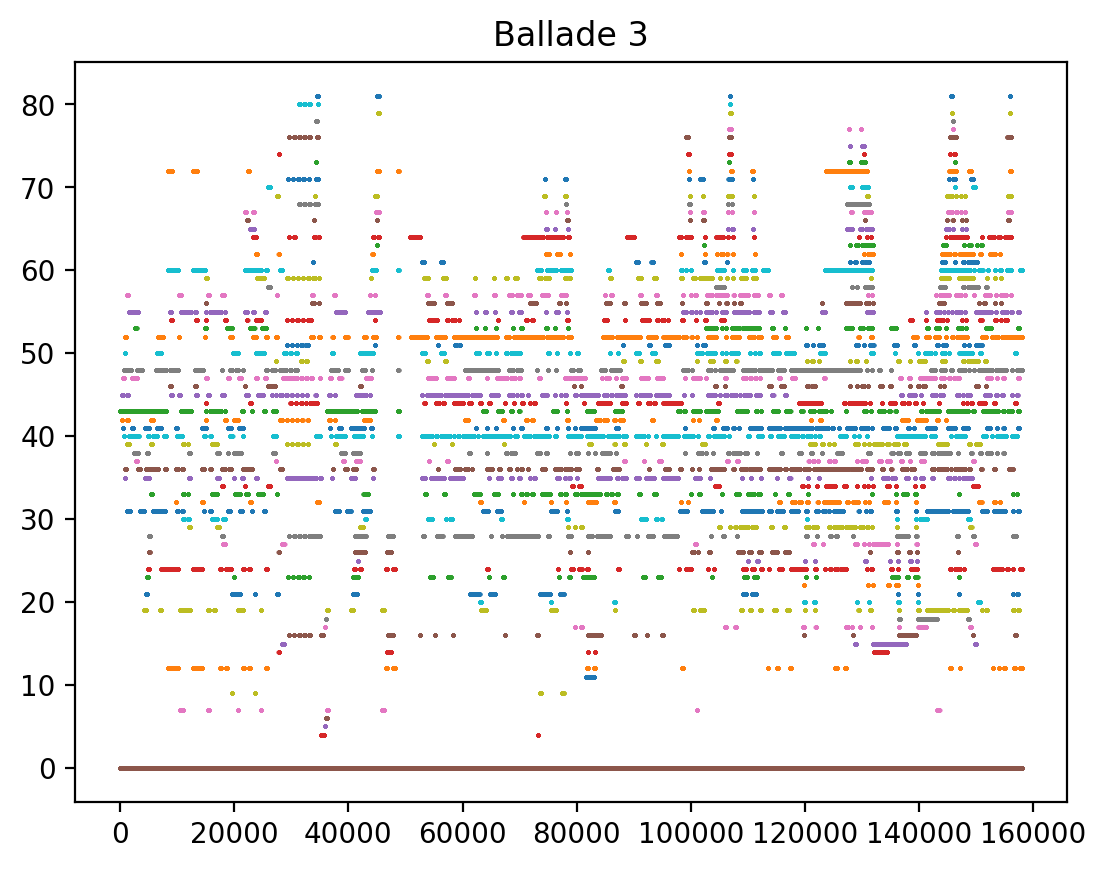

In [84]:
plt.plot(range(ballade3_array.shape[0]), np.multiply(np.where(ballade3_array>0, 1, 0), range(1, 107)), marker='.', markersize=1, linestyle='')
plt.title("Ballade 3")
plt.show()

In [85]:
def arry2mid(ary, tempo=500000):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 106]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new

In [89]:
ballade3_new = arry2mid(ballade3_array, 625000)
ballade3_new.save('../../data_test/Output_midi/ballade3_new.mid')

In [91]:
# Using berceuse as example image
berceuse = mido.MidiFile('../../data_raw/berceuse.mid', clip=True)
berceuse.tracks

[MidiTrack([
   MetaMessage('time_signature', numerator=6, denominator=8, clocks_per_click=12, notated_32nd_notes_per_beat=8, time=0),
   MetaMessage('set_tempo', tempo=800000, time=0),
   MetaMessage('marker', text='F. Chopin: Berceuse, Op. 57 (realtime sequence by Ron Lubetsky, M.D.)', time=0),
   MetaMessage('set_tempo', tempo=1000000, time=41760),
   MetaMessage('set_tempo', tempo=909091, time=2160),
   MetaMessage('set_tempo', tempo=1052632, time=1440),
   MetaMessage('set_tempo', tempo=909091, time=720),
   MetaMessage('set_tempo', tempo=869565, time=720),
   MetaMessage('set_tempo', tempo=952381, time=18000),
   MetaMessage('set_tempo', tempo=869565, time=1440),
   MetaMessage('end_of_track', time=0)]),
 MidiTrack([
   MetaMessage('track_name', name='Copyright 1997 acuity2020@aol', time=0),
   Message('program_change', channel=0, program=0, time=0),
   Message('control_change', channel=0, control=64, value=0, time=146),
   Message('note_on', channel=0, note=37, velocity=59, time

In [94]:
berceuse_array = mid2array(berceuse)
berceuse_array.shape

(67473, 106)

In [97]:
berceuse_new = arry2mid(berceuse_array, 1000000)
berceuse_new.save('../../data_test/Output_midi/berceuse_new.mid')

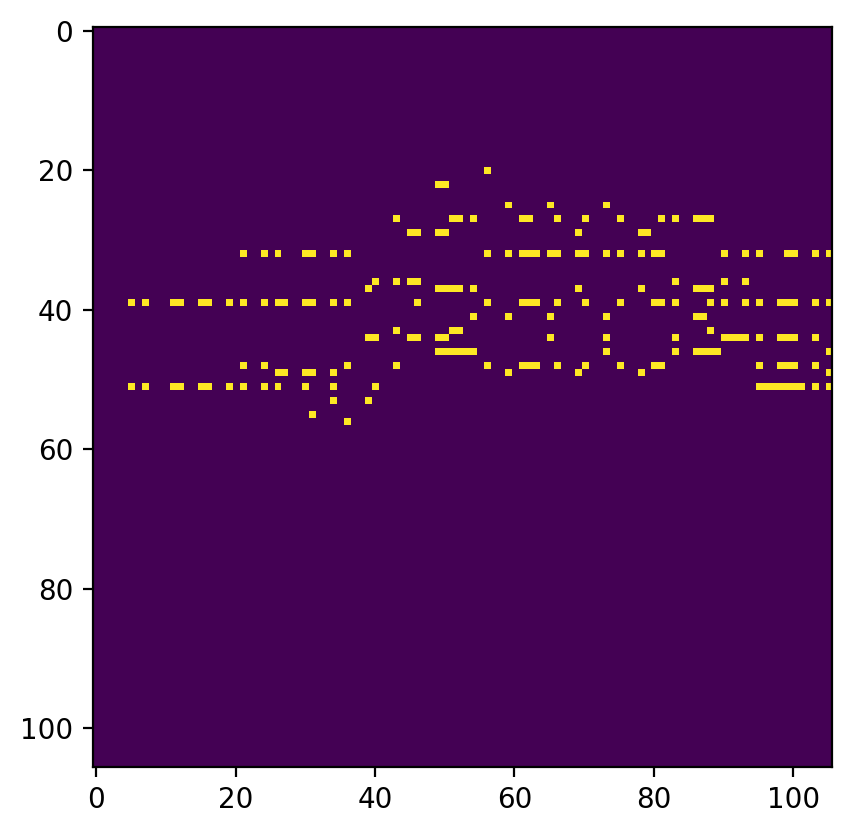

In [111]:
# Testing translation from a cleaned image
import numpy as np 

clean_ballade2_image = ImageOps.grayscale(Image.open('../../data_test/Input_image_cleaned/ballade2/ballade2_instrument_0_0.png'))
plt.imshow(clean_ballade2_image)

In [112]:
clean_ballade2_array = np.array(clean_ballade2_image)*255

In [114]:
clean_ballade2_midi = arry2mid(clean_ballade2_array, 500000)
clean_ballade2_midi.save('../../data_test/Output_midi/clean_ballade2_midi_new.mid')